In [13]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os

def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


# Data Retrieval
    ## Select either Monethly (h0) daily (h1) or Hourly(h2) using wild card

In [14]:
# Directory where the netCDF files are located
data_directory = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly'  # Current directory. Adjust this if your files are elsewhere.

# File pattern
# h2 is two years of daily files, each file contains 24 hourly output  
file_pattern = "i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.198*nc" #1985 to 1989 5 years of data

file_path_pattern = os.path.join(data_directory, file_pattern)

## Get the list of files using the pattern

In [15]:
file_list = glob.glob(file_path_pattern)
file_list.sort(key=lambda x: os.path.basename(x).split('.')[-2])


In [16]:
# os.listdir(directory)
file_list

['/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-01.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-02.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-03.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-04.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-05.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-06.nc',
 '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-07.nc',
 '/Trex/case_results

## Open the files using Dask and Xarray

In [17]:
ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4')
# ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4')

## Convert the cftime.DatetimeNoLeap objects to pandas Timestamps

In [18]:
ds = convert_time(ds)

## examine the xarray object

In [19]:
ds

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 60, lon: 288,
                    lat: 192, hist_interval: 2)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-03-01 ... 1990-01-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(2, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

# Define Variables to Report

In [20]:
variables = ['TSA', 'RH2M', 'RAIN']

#  Filter global summer

In [21]:
# Filter dataset by the year 2000
ds_sel = ds # ds.sel(time=slice('1985', '1994'))
ds_sel

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 60, lon: 288,
                    lat: 192, hist_interval: 2)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-03-01 ... 1990-01-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mcsec          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mdcur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    mscur          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nstep          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(2, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

In [26]:
def set_unwanted_to_nan(ds):
    # Condition for JJA in the Northern Hemisphere
    condition_jja_nh = (ds['time.season'] == 'JJA') & (ds['lat'] >= 0)

    # Condition for DJF in the Southern Hemisphere
    condition_djf_sh = (ds['time.season'] == 'DJF') & (ds['lat'] < 0)

    # # Set grid cells to NaN where TSA_U is null
    # condition_tsa_u_not_null = ds['TSA_U'].notnull()

    # Combine conditions for the desired data, set others to NaN
    condition = (condition_jja_nh | condition_djf_sh) #& condition_tsa_u_not_null

    # Apply condition, keeping structure intact
    ds_filtered = ds.where(condition, drop=True)

    return ds_filtered

In [27]:
ds_summer = set_unwanted_to_nan(ds_sel)
ds_summer

<xarray.Dataset>
Dimensions:        (time: 30, lat: 192, hist_interval: 2, lon: 288,
                    levgrnd: 25, levlak: 10, levdcmp: 1)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) datetime64[ns] 1985-02-01 1985-06-01 ... 1990-01-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (time, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    mcsec          (time, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    mdcur          (time, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    mscur          (time, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    nstep          (time, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    time_bounds    (time, hist_interval, lat) object dask.array<chunksize=(1, 2, 192), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

In [29]:
ds_summer.isel(time=0).dropna(dim='lat', how='all')  #printonly

<xarray.Dataset>
Dimensions:        (lat: 96, hist_interval: 2, lon: 288, levgrnd: 25,
                    levlak: 10, levdcmp: 1)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
    time           datetime64[ns] 1985-02-01
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 ... -2.356 -1.414 -0.4712
Dimensions without coordinates: hist_interval
Data variables: (12/76)
    mcdate         (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec          (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur          (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur          (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep          (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds    (hist_interval, lat) object dask.array<chunksize=(2, 96), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
    WASTEHEAT      (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
    WBA            (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
    WBA_R          (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
    WBA_U          (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
    WIND           (lat, lon) float32 dask.array<chunksize=(96, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

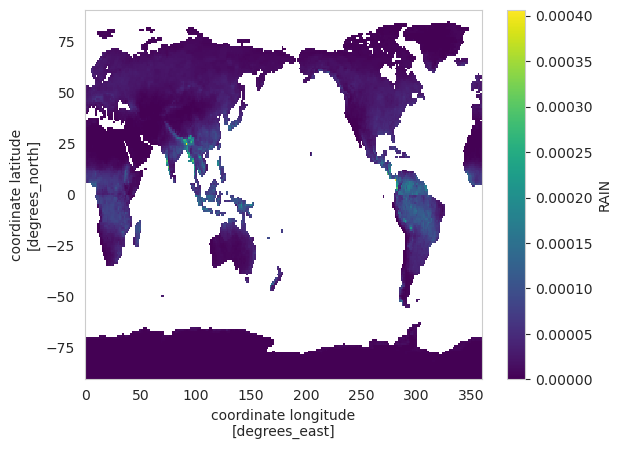

In [25]:
#average of RAIN variable for summer
ds_rain_mean = ds_summer['RAIN'].mean(dim='time')
ds_rain_mean.plot()

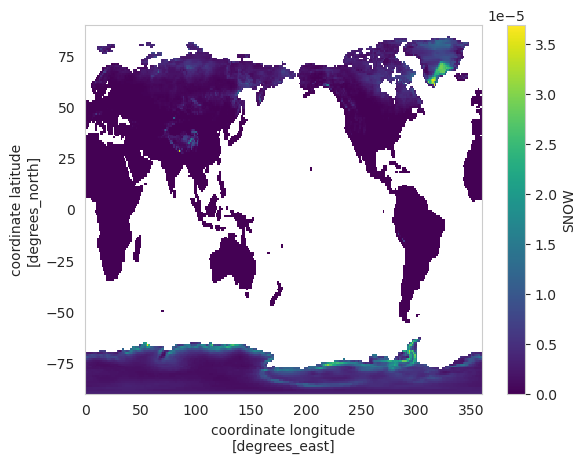

In [35]:
ds_summer['SNOW'].mean(dim='time').plot()

In [31]:
ds_summer['Precip'] = ds_summer['RAIN'] + ds_summer['SNOW']

In [40]:
ds_summer['Precip']

<xarray.DataArray 'Precip' (time: 30, lat: 192, lon: 288)>
dask.array<add, shape=(30, 192, 288), dtype=float32, chunksize=(2, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1985-02-01 1985-06-01 ... 1990-01-01
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [51]:
# Calculate the number of days in each month
days_in_month = ds_summer.time.dt.days_in_month

# Create a new DataArray that weights the Precip values by the number of days in each month
weighted_precip = ds_summer['Precip'] * days_in_month

# Group by year and sum to get the total annual Precip value, weighted by days
annual_precip = weighted_precip.groupby('time.year').sum(dim='time')

# The result is an xarray DataArray with annual total values for 'Precip'
year(annual_precip.mean(dim='year')* 3600 * 24) # printonly

array(57.25077569)

In [39]:
ds_summer['Precip'].mean().values * 3600 * 24

1.7867683083750308

In [ ]:

#average for yearly total RAIN
yearly_avg_rain: xr.core.dataarray.DataArray = ds['RAIN'].sum(dim='time')/10.0
yearly_avg_rain = yearly_avg_rain.compute() 

In [ ]:
yearly_avg_rain

In [ ]:
df =yearly_avg_rain.to_dataframe(name='RAIN')
df